In [5]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts, start_run, end_run, keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')



In [6]:
#mlflow-credentials
os.environ['AWS_ACCESS_KEY_ID'] = 'alex'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'alex1234'


# Artifactory credentials
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://192.168.120.127:9000/'

# MLflow tracking server uri
mlflow.set_tracking_uri("http://192.168.120.127:5555/")

#__log experiment in mlflow
mlflow.set_experiment('Keras_Simple_Model')

<Experiment: artifact_location='s3://mlflow/23', creation_time=None, experiment_id='23', last_update_time=None, lifecycle_stage='active', name='Keras_Simple_Model', tags={}>

In [7]:
IMG_SIZE = 256
SPLIT = 0.1
EPOCHS = 20
BATCH_SIZE = 64

In [8]:
df = pd.read_csv("/media/HDD/shared_data/data/ki_in_mrt/Training_data_alex_T1_170123.csv")
df_abnormal = df[df["Disease"]=="abnormal"]
df_normal = df[df["Disease"]=="normal"]
print(len(df))
print(len(df_normal))
print(len(df_abnormal))

22271
11611
10660


/media/HDD/shared_data/data/ki_in_mrt/_png/0849_423622_T1_TRA_GAD/0000001.png


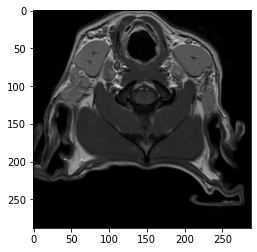

/media/HDD/shared_data/data/ki_in_mrt/_png/0161_T0418938_T1_DOR/0000043.png


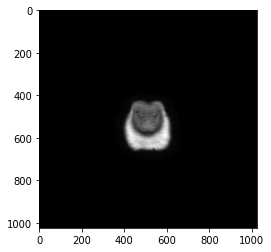

/media/HDD/shared_data/data/ki_in_mrt/_png/0159_T0419386_T1_DOR/0000021.png


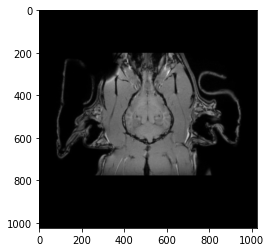

In [9]:
counter = 0
    
for index,row in df_normal.iterrows():
    counter+=1
    img = cv2.imread(row["png_file"])
    print(row["png_file"])
    plt.imshow(img)
    plt.show()
    if counter==3:
        break

In [10]:
X=[]
Y=[]

for index,row in df_normal.iterrows():
    img = cv2.imread(row["png_file"],0)

    X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
    Y.append(0)

for index,row in df_abnormal.iterrows():
    img = cv2.imread(row["png_file"],0)
    X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
    Y.append(1)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values



In [11]:
X_t, X_test, Y_t, Y_test = train_test_split(
X, one_hot_encoded_Y, test_size = SPLIT, stratify=one_hot_encoded_Y,random_state=333)
print("train+val: ", len(X_t), "| test: ", len(X_test))

X_train, X_val, Y_train, Y_val = train_test_split(
X_t, Y_t, test_size = SPLIT, random_state = 199)
print("train: ",len(X_train),"| validation: ",  len(X_val))

train+val:  20043 | test:  2228
train:  18038 | validation:  2005


In [12]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							1),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(2, activation='softmax')
])



2023-01-17 13:33:29.123042: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 13:33:29.782610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10073 MB memory:  -> device: 0, name: GeForce RTX 3080 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-01-17 13:33:29.783421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10092 MB memory:  -> device: 1, name: GeForce RTX 3080 Ti, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.98:
            print('\n Validation accuracy has reached upto 98%\
            so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience = 3,
                monitor = 'val_accuracy',
                restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                    patience = 2,
                    factor = 0.5,
                    verbose = 1)


In [15]:
mlflow.end_run()
mlflow.start_run()
mlflow.keras.autolog()

In [16]:

history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])
# mlflow.keras.log_model(model, "keras_model_mlflow")
mlflow.end_run()

2023/01/17 13:34:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-parameter failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-parameter (Caused by ResponseError('too many 500 error responses'))


Epoch 1/20


2023-01-17 13:34:33.601396: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-01-17 13:34:35.068897: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


282/282 [==============================] - 14s 40ms/step - loss: 0.6146 - accuracy: 0.6897 - val_loss: 0.4872 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 2/20
282/282 [==============================] - 10s 37ms/step - loss: 0.3559 - accuracy: 0.8479 - val_loss: 0.2683 - val_accuracy: 0.8963 - lr: 0.0010
Epoch 3/20
281/282 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9197

2023/01/17 13:36:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 252ms/step - loss: 0.2093 - accuracy: 0.9197 - val_loss: 0.2176 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 4/20
281/282 [============================>.] - ETA: 0s - loss: 0.1086 - accuracy: 0.9614

2023/01/17 13:37:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.1088 - accuracy: 0.9614 - val_loss: 0.1890 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 5/20
281/282 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9766

2023/01/17 13:38:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.0698 - accuracy: 0.9767 - val_loss: 0.2109 - val_accuracy: 0.9397 - lr: 0.0010
Epoch 6/20
281/282 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9740
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


2023/01/17 13:39:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 70s 251ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 0.2553 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 7/20
281/282 [============================>.] - ETA: 0s - loss: 0.0311 - accuracy: 0.9898

2023/01/17 13:40:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.2227 - val_accuracy: 0.9506 - lr: 5.0000e-04
Epoch 8/20
281/282 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9963
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


2023/01/17 13:42:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 70s 251ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.2260 - val_accuracy: 0.9491 - lr: 5.0000e-04
Epoch 9/20
281/282 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9977

2023/01/17 13:43:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.2235 - val_accuracy: 0.9521 - lr: 2.5000e-04
Epoch 10/20
281/282 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9978
Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


2023/01/17 13:44:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 70s 251ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.2287 - val_accuracy: 0.9521 - lr: 2.5000e-04
Epoch 11/20
281/282 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9990

2023/01/17 13:45:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.2324 - val_accuracy: 0.9526 - lr: 1.2500e-04
Epoch 12/20
281/282 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994
Epoch 00012: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


2023/01/17 13:46:43 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 70s 251ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.2399 - val_accuracy: 0.9521 - lr: 1.2500e-04
Epoch 13/20
281/282 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.9991

2023/01/17 13:47:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 70s 251ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.2415 - val_accuracy: 0.9526 - lr: 6.2500e-05
Epoch 14/20
281/282 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9993
Epoch 00014: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


2023/01/17 13:49:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


282/282 [==============================] - 71s 251ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.2416 - val_accuracy: 0.9526 - lr: 6.2500e-05


2023-01-17 13:49:05.034873: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp0_dlrkli/model/data/model/assets


2023/01/17 13:49:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0_dlrkli/model, flavor: tensorflow), fall back to return ['tensorflow==2.7.0']. Set logging level to DEBUG to see the full traceback.
2023/01/17 13:50:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=7ef496bfd5c043889872a4e098e135e4&run_id=7ef496bfd5c043889872a4e098e135e4 (Caused by ResponseError('too many 500 error responses'))


MlflowException: API request to http://192.168.120.127:5555/api/2.0/mlflow/runs/update failed with exception HTTPConnectionPool(host='192.168.120.127', port=5555): Max retries exceeded with url: /api/2.0/mlflow/runs/update (Caused by ResponseError('too many 500 error responses'))

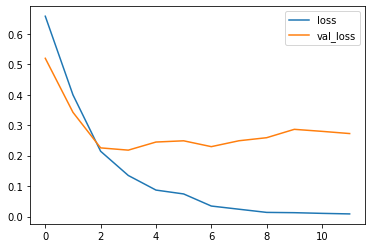

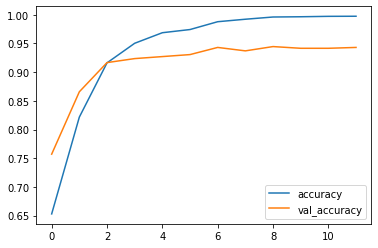

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [ ]:
Y_pred = model.predict(X_test)

Y_test = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
metrics.confusion_matrix(Y_test, Y_pred)


array([[1077,   85],
       [  50, 1016]])

In [ ]:
print(metrics.classification_report(Y_test, Y_pred,
									target_names=["normal","abnormal"]))


              precision    recall  f1-score   support

      normal       0.96      0.93      0.94      1162
    abnormal       0.92      0.95      0.94      1066

    accuracy                           0.94      2228
   macro avg       0.94      0.94      0.94      2228
weighted avg       0.94      0.94      0.94      2228



In [ ]:
# from numba import cuda 
# device = cuda.select_device(0)
# device.reset()
# device = cuda.select_device(1)
# device.reset()

In [ ]:
for i,j in zip(Y_test,Y_pred):
    print(f"actual {i} <--> {j} predicted")

actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 0 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 1 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 0 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--> 0 predicted
actual 1 <--> 0 predicted
actual 1 <--> 1 predicted
actual 0 <--

In [ ]:
a=5